# Linear MNIST Classifier

### Imports

In [1]:
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 1.12.0


### MNIST Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(f"Initial shape of training set: {train_images.shape}.")
print(f"Initial shape of training labels: {train_labels.shape}.")
print(f"Initial shape of test set: {test_images.shape}.")
print(f"Initial shape of test labels: {test_labels.shape}.")
train_images = train_images.reshape((train_images.shape[0], 784)) / 255 # Rescale to have values in [0, 1]
test_images = test_images.reshape((test_images.shape[0], 784)) / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10) # Convert to one-hot encoding
test_labels = tf.keras.utils.to_categorical(test_labels, 10)
print(f"New shape of training set: {train_images.shape}.")
print(f"New shape of training labels: {train_labels.shape}.")
print(f"New shape of test set: {test_images.shape}.")
print(f"New shape of test labels: {test_labels.shape}.")

Initial shape of training set: (60000, 28, 28).
Initial shape of training labels: (60000,).
Initial shape of test set: (10000, 28, 28).
Initial shape of test labels: (10000,).
New shape of training set: (60000, 784).
New shape of training labels: (60000, 10).
New shape of test set: (10000, 784).
New shape of test labels: (10000, 10).


### Batch Generation

In [3]:
def next_batch(batch_size, data, labels): 
    """Return an array of `batch_size` random samples and labels."""
    indices = np.random.randint(low=0, high=data.shape[0], size=batch_size)
    data_batch = data[indices]
    labels_batch = labels[indices]
    return data_batch, labels_batch

### Sample Images

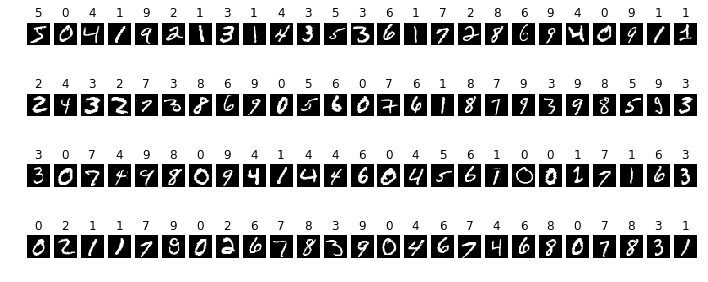

In [32]:
ROWS, COlS = 4, 20
f, axes = plt.subplots(ROWS, COLS, figsize=(12,5)) # image size is in inches
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        axes[i, j].imshow(train_images[index].reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f"{train_labels[index].argmax()}")
        axes[i, j].axis('off')

### Tensorflow Graph

In [5]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [6]:
with tf.name_scope('Inputs'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='image') # Nx784
    y = tf.placeholder(tf.float32, shape=[None, 10], name='label')  # Nx10
with tf.name_scope('LinearModel'):
    W = tf.Variable(tf.zeros([784, 10]), name='weights')  # 784x10
    b = tf.Variable(tf.zeros([10]), name='bias') # 1x10
    y_hat = tf.matmul(x, W) + b # Nx10
    variable_summaries(y_hat)

with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat, name='softmax'))
    tf.summary.scalar('loss', loss)
with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)
summarize_all = tf.summary.merge_all()

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1)), tf.float32)) # % of correct predictions

### Execution

In [9]:
NUM_ITERATIONS, BATCH_SIZE = 1000, 300 
start_time = time.time()
init = tf.global_variables_initializer()
log_path = './TBLogs/'
np.random.seed(42) 
with tf.Session() as sess:
    tbWriter = tf.summary.FileWriter(log_path, sess.graph)
    sess.run(init)    
    for i in range(NUM_ITERATIONS):        
        images, labels = next_batch(BATCH_SIZE, train_images, train_labels) # Nx784 and Nx10
        _, summary = sess.run([optimizer, summarize_all], feed_dict={x:images, y:labels})
        tbWriter.add_summary(summary, i)
        if (i % 100 == 0) or (i == num_iterations-1):
            l = sess.run(loss, feed_dict={x:images, y:labels})
            end_time = time.time()
            acc = sess.run(accuracy, feed_dict={y:labels, x:images})
            print(f"Step {i} complete after {end_time-start_time:.1f}s, with loss {l:.2f} and training accuracy {acc*100:.1f}%.")
    tbWriter.close()
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.1f}s.")
    # Show accuracy on both data sets
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:train_images, y:train_labels})
    print(f"Accuracy on training data: {acc*100:.1f}%.")
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:test_images, y:test_labels})
    print(f"Accuracy on test data: {acc*100:.1f}%.")    


Step 0 complete after 0.2s, with loss 1.78 and training accuracy 44.7%.
Step 100 complete after 0.6s, with loss 0.35 and training accuracy 91.3%.
Step 200 complete after 1.1s, with loss 0.28 and training accuracy 93.0%.
Step 300 complete after 1.6s, with loss 0.27 and training accuracy 92.7%.
Step 400 complete after 2.0s, with loss 0.30 and training accuracy 93.0%.
Step 500 complete after 2.4s, with loss 0.26 and training accuracy 92.7%.
Step 600 complete after 2.9s, with loss 0.27 and training accuracy 93.0%.
Step 700 complete after 3.4s, with loss 0.37 and training accuracy 92.0%.
Step 800 complete after 3.8s, with loss 0.30 and training accuracy 92.0%.
Step 900 complete after 4.3s, with loss 0.29 and training accuracy 92.3%.
Elapsed time: 5.0s.
Accuracy on training data: 92.0%.
Accuracy on test data: 92.0%.


### Prediction against Test Data

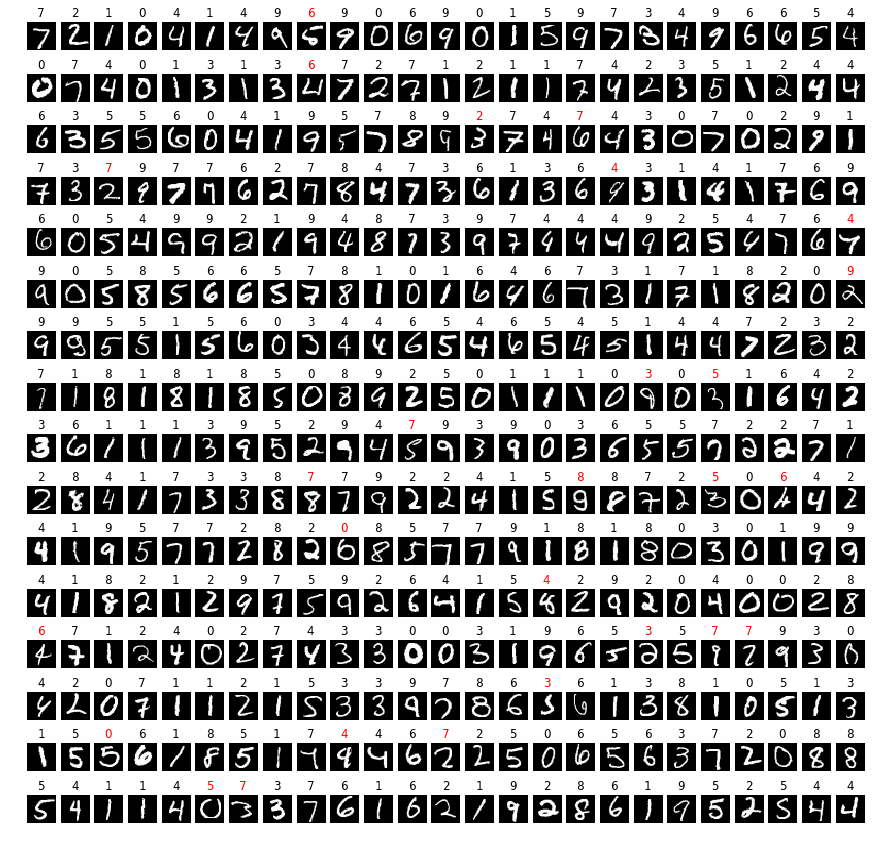

In [8]:
ROWS, COLS = 16, 25
np.set_printoptions(precision=3, suppress=True)
fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 15)) # image size is in inches
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        output = np.matmul(test_images[index], weights) + bias # score = image * weights + bias
        probabilities = np.exp(output) / np.exp(output).sum() # activation fn converts scores to probalities
        color = 'k' if (probabilities.argmax() == test_labels[index].argmax()) else 'r'
        axes[i, j].imshow(image.reshape((28, 28)), cmap='gray')
        axes[i, j].set_title(f"{probabilities.argmax()}", color=color)
        axes[i, j].axis('off')

In [9]:
errors = 0
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        image = test_images[index]
        output = np.matmul(image, weights) + bias 
        probabilities = np.exp(output) / np.exp(output).sum() # activation fn converts scores to probabilities
        label = test_labels[index].argmax()
        if (probabilities.argmax() != label):
            print(f"Digit #{index} is {label} but predicted as {output.argmax()}. Probabilities:")
            print(probabilities)
            errors += 1
print(f"{errors} error(s) out of {rows*cols} ({errors*100/rows/cols:.1f}%).")

Digit #8 is 5 but predicted as 6. Probabilities:
[0.    0.    0.    0.    0.001 0.    0.999 0.    0.    0.   ]
Digit #33 is 4 but predicted as 6. Probabilities:
[0.388 0.    0.007 0.    0.028 0.051 0.524 0.    0.002 0.   ]
Digit #63 is 3 but predicted as 2. Probabilities:
[0.    0.    0.604 0.34  0.    0.001 0.    0.    0.053 0.002]
Digit #66 is 6 but predicted as 7. Probabilities:
[0.002 0.001 0.264 0.102 0.051 0.003 0.209 0.356 0.01  0.003]
Digit #77 is 2 but predicted as 7. Probabilities:
[0.001 0.004 0.402 0.007 0.002 0.013 0.005 0.49  0.011 0.065]
Digit #92 is 9 but predicted as 4. Probabilities:
[0.001 0.003 0.022 0.023 0.508 0.031 0.01  0.028 0.069 0.306]
Digit #124 is 7 but predicted as 4. Probabilities:
[0.    0.    0.    0.    0.698 0.    0.    0.151 0.011 0.14 ]
Digit #149 is 2 but predicted as 9. Probabilities:
[0.    0.013 0.005 0.025 0.058 0.006 0.019 0.001 0.034 0.838]
Digit #193 is 9 but predicted as 3. Probabilities:
[0.    0.    0.002 0.533 0.196 0.011 0.001 0.051 0.0

### Calibrated Weights

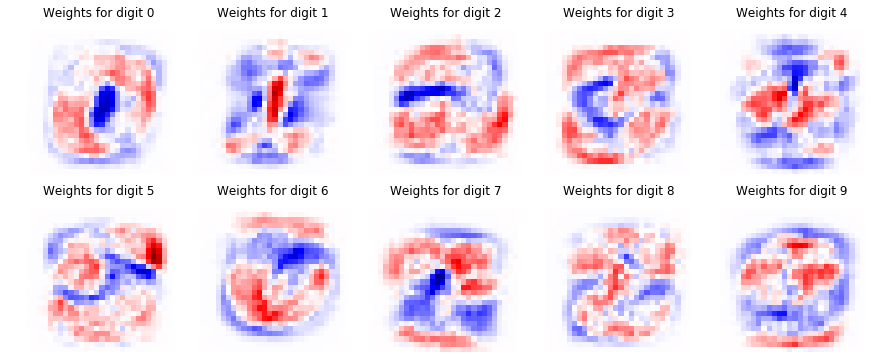

In [24]:
ROWS, COLS = 2, 5
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(15, 6)) # image size is in inches
abs_max = max(abs(weights.min()), abs(weights.max()))
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        w = weights[:, index].reshape(28,28)
        img = axes[i, j].matshow(w, cmap='seismic', vmin=-abs_max, vmax=abs_max)
        # plt.colorbar(img, ax=axes[i, j])
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Weights for digit {index}')

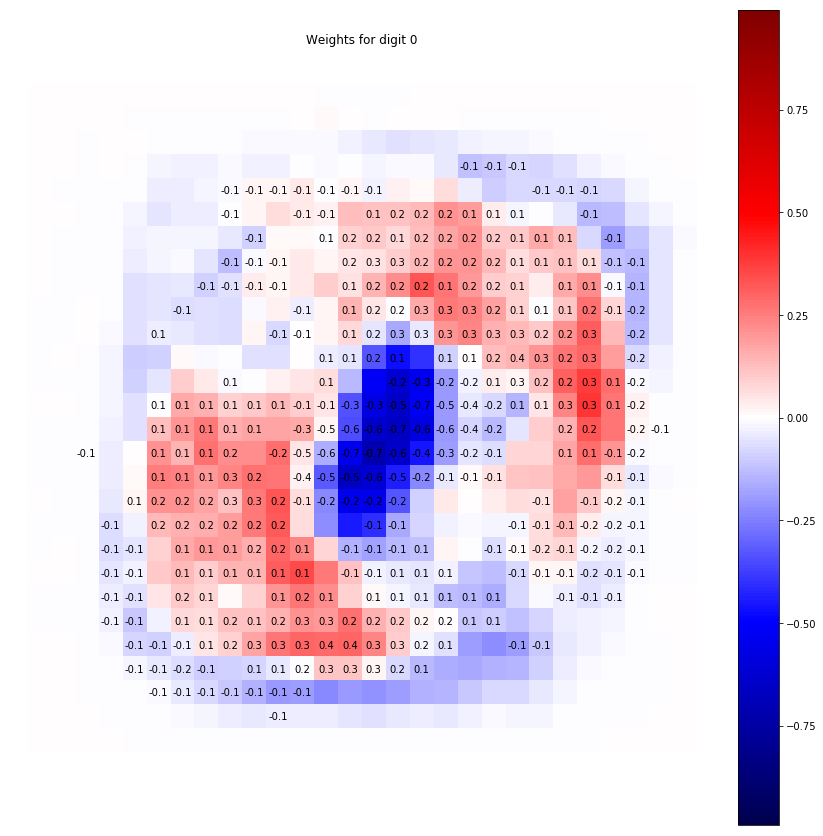

In [26]:
index = 0
w = weights[:, index].reshape(28,28)
fig, ax = plt.subplots(figsize=(15, 15))
for i in range(28):
    for j in range(28):
        if (abs(w[i, j]) > 0.05):
            ax.text(i, j, f'{w[i, j]:.1f}', va='center', ha='center')
img = ax.matshow(w, cmap='seismic', vmin=-abs_max, vmax=abs_max)
ax.set_title(f'Weights for digit {index}')
plt.colorbar(img)
ax.axis('off');

# Keras Implementation

### Model Definition and Calibration

In [42]:
model = tf.keras.Sequential()
layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax, input_shape=(784,)) # Dense layer of 10 units
model.add(layer)
sgd = tf.keras.optimizers.SGD(lr=0.5, decay=0)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [44]:
np.random.seed(42) # Make results reproducible
model.fit(train_images, train_labels, epochs=5, batch_size=BATCH_SIZE, shuffle=True);

Epoch 1/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.2884 - acc: 0.9188
Epoch 2/5
60000/60000 [==============================] - 1s 18us/step - loss: 0.2839 - acc: 0.9202
Epoch 3/5
60000/60000 [==============================] - 1s 16us/step - loss: 0.2807 - acc: 0.9219
Epoch 4/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.2775 - acc: 0.9229
Epoch 5/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.2752 - acc: 0.9234


### Output Summary

In [45]:
scores = model.predict(test_images)
check = np.equal(scores.argmax(axis=1), test_labels.argmax(axis=1))
print(f"Accuracy on test data = {100*check.sum()/check.shape[0]}%")

Accuracy on test data = 92.38%


Accuracy = 93.0%


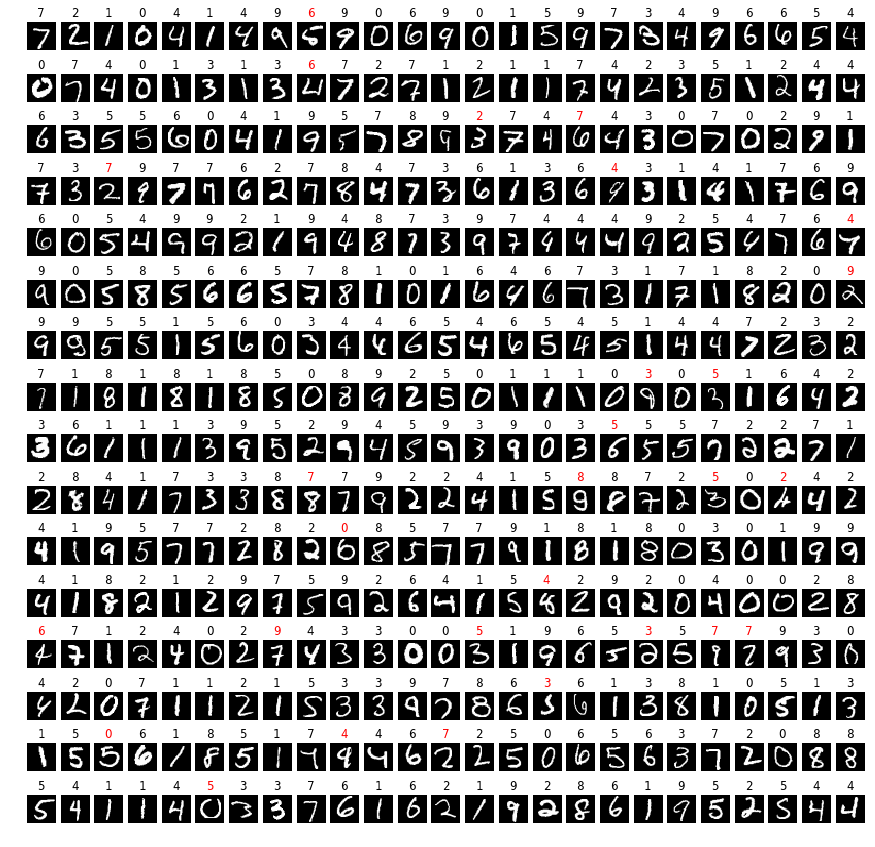

In [31]:
ROWS, COLS = 16, 25
scores = model.predict(test_images[0:ROWS*COLS])
check = np.equal(scores.argmax(axis=1), test_labels[0:ROWS*COLS].argmax(axis=1))
print(f"Accuracy = {100*check.sum()/check.shape[0]}%")
np.set_printoptions(precision=3, suppress=True)
fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 15)) # image size is in inches
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        color = 'k' if (scores[index].argmax() == test_labels[index].argmax()) else 'r'
        axes[i, j].imshow(test_images[index].reshape((28, 28)), cmap='gray')
        axes[i, j].set_title(f"{scores[index].argmax()}", color=color)
        axes[i, j].axis('off')

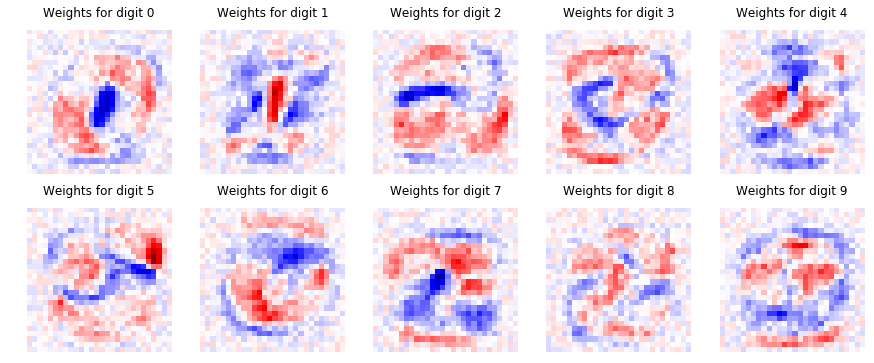

In [46]:
weights = layer.get_weights()[0]
ROWS, COLS = 2, 5
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(15, 6)) # image size is in inches
abs_max = max(abs(weights.min()), abs(weights.max()))
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        w = weights[:, index].reshape(28,28)
        img = axes[i, j].matshow(w, cmap='seismic', vmin=-abs_max, vmax=abs_max)
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Weights for digit {index}')